# COVID-19 NLP Analytics: Potential Vaccines and Transmission
### Sam Weinberg (sam.weinberg@mail.utoronto.ca)
### Apr. 9th/2020

With the spread of COVID-19, a global effort has begun in the search for a viable vaccine. Additionally, governments are working together in an effort to implement effective policies to mitigate the spread. The dataset used in this notebook contains metadata on research papers related to viruses, vaccines, and epidemiology. The goal of this analysis is to use NLP to analyze over 100,000 papers to discover powerful insights. Specifically, I wanted to explore two specific questions. 

- How can we use past vaccine efforts to guide our search for a new vaccine?
- What are the most common modes of transmission for similar viruses, and how can governments use this to implement effective policy?


# 1. Data Cleaning

In [1]:
import numpy as np 
import pandas as pd 

# load the meta data from the CSV file 
# Include 'sha', 'has_full_text' and 'full_text_file' to extract full text from .json
df=pd.read_csv('metadata.csv', usecols=['title','abstract','authors','doi','publish_time','sha','has_full_text','full_text_file'])
print (df.shape)

#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#drop NANs 
df = df.dropna()

# convert abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()

#show 10 lines of the new dataframe
print (df.shape)
df.head()

(45774, 8)
(27527, 8)


,sha,title,doi,abstract,publish_time,authors,has_full_text,full_text_file
0,f056da9c64fbf00a4645ae326e8a4339d015d155,SIANN: Strain Identification by Alignment to N...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,True,biorxiv_medrxiv
1,daf32e013d325a6feb80e83d15aabc64a48fae33,Spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,True,biorxiv_medrxiv
2,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,Sequencing of the human IG light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,True,biorxiv_medrxiv
3,4da8a87e614373d56070ed272487451266dce919,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,True,biorxiv_medrxiv
4,eccef80cfbe078235df22398f195d5db462d8000,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,True,biorxiv_medrxiv


### Research Questions

For my analysis, I would like to explore the following questions: What are the different types of potential vaccines being tested? What are the most prominent methods of transmission? 

To do this, I would like to further narrow down my dataset to only articles relating to the subjects of vaccine and transmission.

In [2]:
# Create two new dataframes
def vaccine_df(abstract):
    if 'vaccine' in abstract:
        return 1
    else:
        return 0
        
df['vaccine'] = df.abstract.apply(vaccine_df)
        
def transmission_df(abstract):
    if 'transmission' in abstract:
        return 1
    else:
        return 0

df['transmission'] = df.abstract.apply(transmission_df)     


df_vaccine = df[df['vaccine'] == 1]
df_transmission = df[df['transmission'] == 1]
df_vaccine = df_vaccine.drop(['vaccine', 'transmission'], axis = 1)
df_transmission = df_transmission.drop(['vaccine', 'transmission'], axis = 1)

print('The shape of the vaccines dataset is: {}'.format(df_vaccine.shape))
print('The shape of the transmission dataset is: {}'.format(df_transmission.shape))

The shape of the vaccines dataset is: (3243, 8)
The shape of the transmission dataset is: (2527, 8)


In [3]:
df_transmission.head()

,sha,title,doi,abstract,publish_time,authors,has_full_text,full_text_file
1,daf32e013d325a6feb80e83d15aabc64a48fae33,Spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,True,biorxiv_medrxiv
4,eccef80cfbe078235df22398f195d5db462d8000,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,True,biorxiv_medrxiv
6,1dd898b5ca1ae70ec0e3cad89fc87a165002a99e,Using heterogeneity in the population structur...,10.1101/017178,"abstractin 2013, u.s. swine producers were con...",2015-03-27,Eamon B. O’Dea; Harry Snelson; Shweta Bansal,True,biorxiv_medrxiv
7,33565294e6bc67fb7ee14dcae6cfdb08148f4ea5,"Big city, small world: Density, contact rates,...",10.1101/018481,macroscopic descriptions of populations common...,2015-04-27,Moritz U. G. Kraemer; T. Alex Perkins; Derek A...,True,biorxiv_medrxiv
14,6499f5c865c3db3bdfc1e969ea940a80d547a5bb,Zika virus outbreak in the Americas: Is Aedes ...,10.1101/044594,summary / abstractcodon usage patterns of viru...,2016-03-30,Azeem Mehmood Butt; Izza Nasrullah; Raheel Qam...,True,biorxiv_medrxiv


# 2. Exploratory Analysis

We will start by using the abstracts to perform some exploratory analysis on the datasets. Later on, we will utilize the full text if available.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
import html
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
try:
    import emoji #If tweepy is already installed on the system
except:
    !pip install emoji

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

try:
    from gensim.models import word2vec
except:
    !pip install gensim
    from gensim.models import word2vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Use this to check for the presence of certain words in abstract
count = 0
keyword1 = 'airborne'

for abstract in df_transmission['abstract']:
    if str(keyword1) in abstract:
        count += 1
print(count)

128


In [6]:
# Clean the text

def clean_text(abstract):
        
    abstract = str(abstract)
    
    # Start by tokenize the abstract (separate it the text into words, or n-grams) with nltk
    word_tokens = nltk.word_tokenize(abstract) 
    
    # Convert text to lowercase as required
    word_tokens = [word.lower() for word in word_tokens]
    
    # Remove stopwords
    STOPWORDS = stopwords.words('english')
    STOPWORDS.append('abstract')
    stop_words = set(STOPWORDS) #import a predefined set of stopwords from the nltk package
    word_tokens = [word for word in word_tokens if not word in stop_words]
    
    # Remove punctuation signs from tokens
    table = str.maketrans('', '', string.punctuation)
    word_tokens = [word.translate(table) for word in word_tokens]
    
    clean_abstract = ' '.join(word_tokens)

    return clean_abstract

In [7]:
df['clean_abstract'] = df.abstract.apply(clean_text)
df_vaccine['clean_abstract'] = df_vaccine.abstract.apply(clean_text)
df_transmission['clean_abstract'] = df_transmission.abstract.apply(clean_text)

In [8]:
df.head()

,sha,title,doi,abstract,publish_time,authors,has_full_text,full_text_file,vaccine,transmission,clean_abstract
0,f056da9c64fbf00a4645ae326e8a4339d015d155,SIANN: Strain Identification by Alignment to N...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,True,biorxiv_medrxiv,0,0,nextgeneration sequencing increasingly used st...
1,daf32e013d325a6feb80e83d15aabc64a48fae33,Spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,True,biorxiv_medrxiv,0,1,emerging disease one infectious epidemic cause...
2,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,Sequencing of the human IG light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,True,biorxiv_medrxiv,0,0,germline variation immunoglobulin gene ig lo...
3,4da8a87e614373d56070ed272487451266dce919,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,True,biorxiv_medrxiv,0,0,deep sequencing clinical samples established t...
4,eccef80cfbe078235df22398f195d5db462d8000,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,True,biorxiv_medrxiv,0,1,developing methods reconstruct transmission hi...


I also created a method of extracting full text form the .json files. Ultimately, the full text was not not utilized in the analysis due to a variety of complications that skewed the results. Due to time constraints, I was unable to write an adequate text cleaning function to handle the different cases. As such, we only use the abstracts in our analysis.

I have included the method to show how the full text can be extracted if required. It is commented out since the .json files are not attached to the submission.

In [9]:
# Lets extract the full text from the .json format to use in our analysis
#import json

# Create example dataframe to show extraction method
#df_full_text_example = df_vaccine

# First we drop articles without full text
#df_full_text_example.drop(df_full_text_example[df_full_text_example['has_full_text'] == False].index)

# Create function that extracts full text using document identification number
#def get_full_text(sample):
    
#    sha = sample['sha'].split(';')[0]
    
#    with open('CORD-19-research-challenge/' + sample['full_text_file'] + '/' + sha + '.json') as f:
#        temp = json.load(f)
        
#    full_text = str()
#    for i in range(len(temp['body_text'])):
#        full_text = full_text + ' ' + temp['body_text'][i]['text']
    
#    return full_text

In [10]:
# Apply function to df
#df_full_text_example['full_text'] = df_full_text_example.apply(get_full_text, axis = 1)

In [11]:
# Show example of appended full text
#df_full_text_example.full_text[17]

' Methods 27 We estimate the effective reproductive number for YF in Angola using disease natural history 28 and case report data. With simple mathematical models of YF transmission, we calculate the 29 infection attack rate (IAR, the proportion of population infected over the course of an epidemic) 30 under varying levels of transmissibility and five-fold fractional-dose vaccine efficacy for two 31 vaccination scenarios: (i) random vaccination in a hypothetical population that is completely 32 susceptible; (ii) the Kinshasa vaccination campaign in July-August 2016 with different age cutoff 33 for fractional-dose vaccines. 34 35 Findings 36 We estimate the effective reproductive number early in the Angola outbreak was between 5·2 37 and 7·1. If vaccine action is all-or-nothing (i.e. a proportion VE of vaccinees receives complete 38 and the remainder receive no protection), n-fold fractionation can dramatically reduce IAR as 39 long as efficacy VE exceeds 1/n. This benefit threshold bec

Now we will generate some preliminary wordclouds to understand the highest frequency words within the vaccine and transmission datasets.

In [12]:
# Use vectorizer to preprocess data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['clean_abstract']) 

In [13]:
# Sum word counts
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [14]:
# Highest word frequencies in full df
words_freq

[('virus', 25466),
 ('infection', 18643),
 ('viral', 17333),
 ('cells', 14792),
 ('respiratory', 14451),
 ('disease', 13637),
 ('viruses', 13568),
 ('patients', 13559),
 ('study', 13515),
 ('results', 12464),
 ('protein', 11379),
 ('human', 10547),
 ('health', 9803),
 ('influenza', 9681),
 ('also', 9305),
 ('using', 9099),
 ('cell', 8928),
 ('may', 8775),
 ('infections', 8321),
 ('clinical', 8266),
 ('data', 8208),
 ('used', 7806),
 ('rna', 7457),
 ('two', 7275),
 ('analysis', 6918),
 ('proteins', 6783),
 ('infectious', 6703),
 ('diseases', 6538),
 ('methods', 6456),
 ('associated', 6432),
 ('expression', 6414),
 ('cases', 6348),
 ('different', 6315),
 ('however', 6259),
 ('control', 6244),
 ('studies', 6110),
 ('host', 6109),
 ('new', 6088),
 ('immune', 6065),
 ('coronavirus', 6053),
 ('one', 6001),
 ('response', 5961),
 ('acute', 5915),
 ('samples', 5792),
 ('high', 5704),
 ('potential', 5700),
 ('identified', 5669),
 ('found', 5628),
 ('treatment', 5625),
 ('including', 5603),
 ('ge

In [15]:
# Append abstracts to generate wordcloud for each subject
vaccine_words = str('')
for abstract in df_vaccine['clean_abstract']:
    vaccine_words = vaccine_words + ' ' + abstract
    
transmission_words = str('')
for abstract in df_transmission['clean_abstract']:
    transmission_words = transmission_words + ' ' + abstract

In [16]:
try:
    import wordcloud
except:
    !pip install wordcloud
    

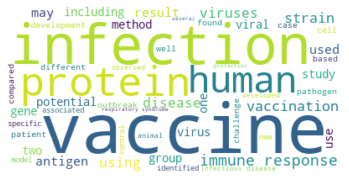

In [17]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Create Word Cloud for vaccines
vaccine_cloud = wordcloud.WordCloud(max_words=50, background_color="white").generate(vaccine_words)
plt.figure()
plt.imshow(vaccine_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

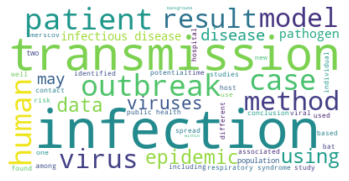

In [18]:
# Create Word Cloud for transmission
transmission_cloud = wordcloud.WordCloud(max_words=50, background_color="white").generate(transmission_words)
plt.figure()
plt.imshow(transmission_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

To understand the potential information that we can discover from text mining this database, we require some preliminary knowledge on vaccines. We would like to understand how vaccines work and identify the main categories of vaccine.

In [19]:
# This image deomnstrates some preliminary research on the different types of potential vaccines
from IPython.display import Image
Image(url='https://163602-560839-raikfcquaxqncofqfm.stackpathdns.com/wp-content/uploads/2018/03/Vaccines-Introduction-and-Types.jpg')

In [20]:
# Lets create a list of the different types of vaccines
vaccine_types = ['attenuated', 'inactivated', 'subunit', 'recombinant', 'polysaccharide', 'conjugate', 'toxoid', 'dna vaccine', 'rna vaccine', 'synthetic peptide']

{'attenuated': 0, 'inactivated': 0, 'subunit': 0, 'recombinant': 0, 'polysaccharide': 0, 'conjugate': 0, 'toxoid': 0, 'dna vaccine': 0, 'rna vaccine': 0, 'synthetic peptide': 0}
{'attenuated': 337, 'inactivated': 206, 'subunit': 210, 'recombinant': 540, 'polysaccharide': 25, 'conjugate': 51, 'toxoid': 7, 'dna vaccine': 163, 'rna vaccine': 8, 'synthetic peptide': 14}


C:\Users\Sam\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


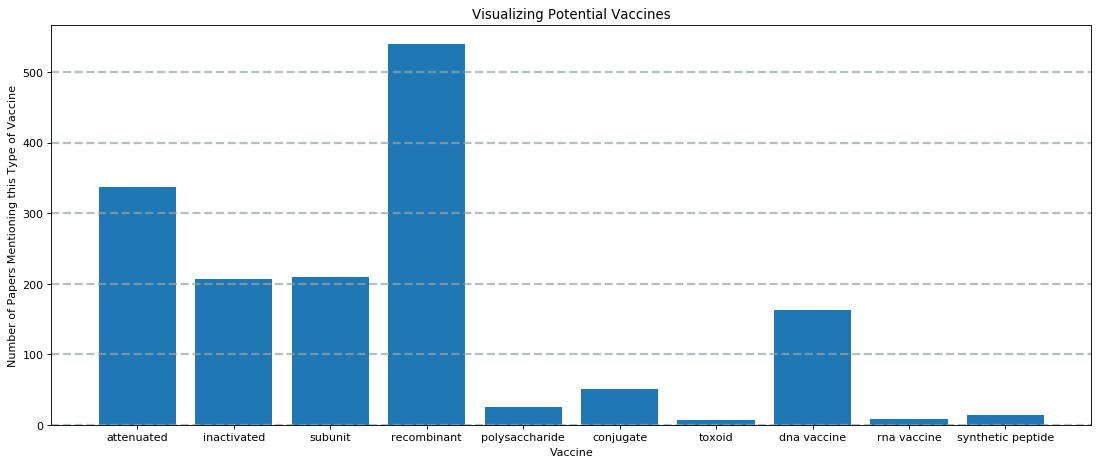

In [21]:
# Lets visualize the # of mentions of different types of vaccines

vaccine_count = dict((vaccine,0) for vaccine in vaccine_types)

print(vaccine_count)

for vaccine in vaccine_count:
    for abstract in df_vaccine['clean_abstract']:
        if str(vaccine) in abstract:
            vaccine_count[vaccine] += 1


print(vaccine_count)

loc = np.arange(len(vaccine_count))
width = 0.35

fig = plt.figure(num=None, constrained_layout=True, figsize=(13, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

ax.bar(vaccine_count.keys(),vaccine_count.values())
ax.set_xticks(loc, tuple(vaccine_types))

ax.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
ax.set_ylabel('Number of Papers Mentioning this Type of Vaccine')
ax.set_xlabel('Vaccine')
ax.set_title('Visualizing Potential Vaccines')
plt.show()

We notice that there are a large number of mentions of the word 'recombinant' in the dataset. After performing additional research and consulting a Medical student, I discovered that recombinant is simply an adjective describing a method of recombining pieces of genetic material, and is not specific to vaccines. Contrastly, the other terms are specific to vaccines (for 'dna' and 'rna' we require the term 'vaccine' following). Note: Subunit usually refers to vaccines but can also refer to subcomponents of dna, etc. We will generate this plot again using the term 'recombinant vaccine' and dropping low frequency terms 'toxoid', 'rna vaccine', 'synthetic peptide', and 'polysaccharide'. 

{'attenuated': 0, 'inactivated': 0, 'subunit': 0, 'recombinant vaccine': 0, 'conjugate': 0, 'dna vaccine': 0}
{'attenuated': 337, 'inactivated': 206, 'subunit': 210, 'recombinant vaccine': 37, 'conjugate': 51, 'dna vaccine': 163}


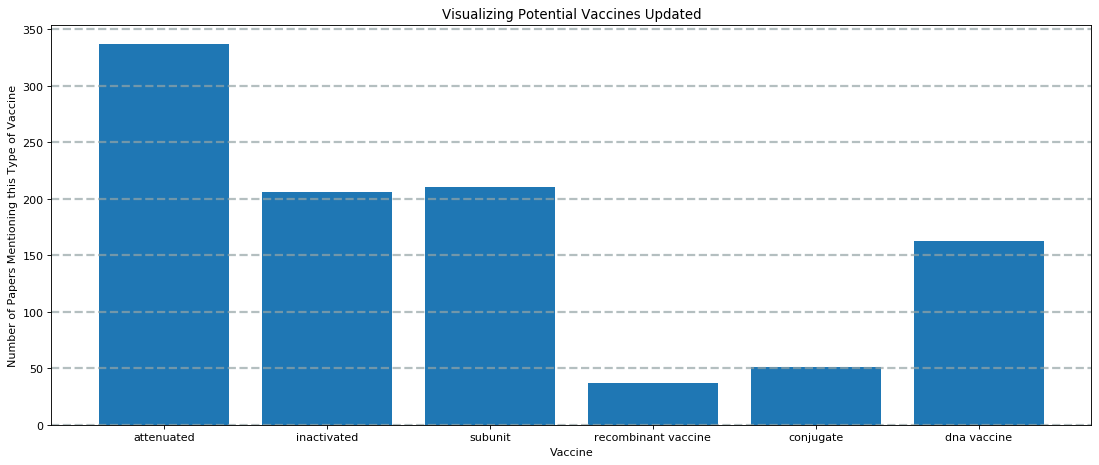

In [22]:
# New vaccine types list
vaccine_types = ['attenuated', 'inactivated', 'subunit', 'recombinant vaccine', 'conjugate', 'dna vaccine']

# Lets visualize the # of mentions of different types of vaccines

vaccine_count = dict((vaccine,0) for vaccine in vaccine_types)

print(vaccine_count)

for vaccine in vaccine_count:
    for abstract in df_vaccine['clean_abstract']:
        if str(vaccine) in abstract:
            vaccine_count[vaccine] += 1


print(vaccine_count)

loc = np.arange(len(vaccine_count))
width = 0.35

fig = plt.figure(num=None, constrained_layout=True, figsize=(13, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

ax.bar(vaccine_count.keys(),vaccine_count.values())
ax.set_xticks(loc, tuple(vaccine_types))

ax.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
ax.set_ylabel('Number of Papers Mentioning this Type of Vaccine')
ax.set_xlabel('Vaccine')
ax.set_title('Visualizing Potential Vaccines Updated')
plt.show()

We can see the number of mentions of 'recombinant vaccine' is far less than the generic term 'recombinant'. An interesting finding here is that 'dna vaccine', which is a new type of vaccine currently being researched, is coming up in a number of papers. 

Now let's perform a similar analysis for transmission methods.

In [23]:
# Diagram demonstrating some modes of transmission

from IPython.display import Image
Image(url='https://www.cdc.gov/csels/dsepd/ss1978/lesson1/images/Figure1.19.jpg')


In [24]:
# Our list of transmission methods is:
transmissions = ['direct', 'vector', 'vehicle', 'droplet', 'airborne']

{'direct': 0, 'vector': 0, 'vehicle': 0, 'droplet': 0, 'airborne': 0}
{'direct': 316, 'vector': 141, 'vehicle': 14, 'droplet': 96, 'airborne': 129}


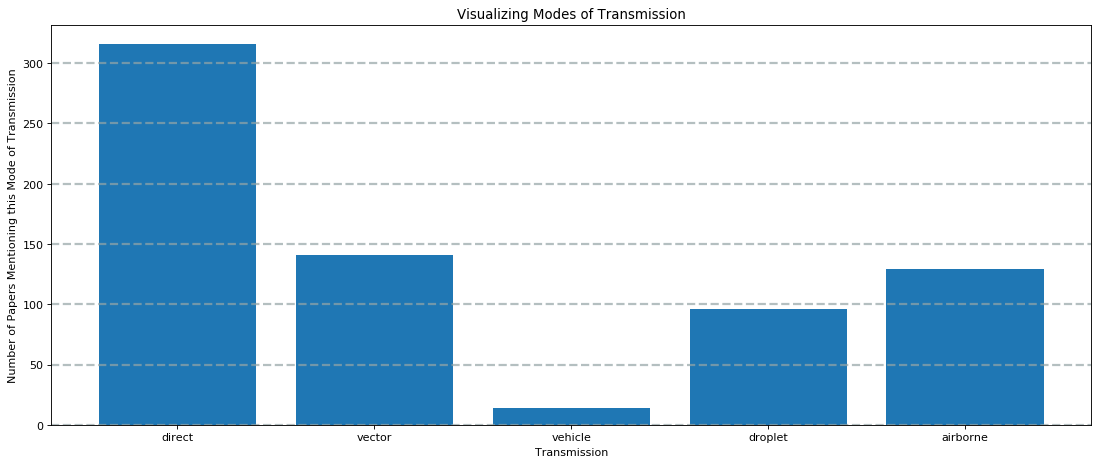

In [25]:
# Lets visualize the # of mentions of different types of transmissions

transmission_count = dict((transmission,0) for transmission in transmissions)

print(transmission_count)

for transmission in transmission_count:
    for abstract in df_transmission['clean_abstract']:
        if str(transmission) in abstract:
            transmission_count[transmission] += 1


print(transmission_count)

loc = np.arange(len(transmission_count))
width = 0.35

fig = plt.figure(num=None, constrained_layout=True, figsize=(13, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

ax.bar(transmission_count.keys(),transmission_count.values())
ax.set_xticks(loc, tuple(vaccine_types))

ax.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
ax.set_ylabel('Number of Papers Mentioning this Mode of Transmission')
ax.set_xlabel('Transmission')
ax.set_title('Visualizing Modes of Transmission')
plt.show()

The word 'direct' is by far the most frequent with 'vector' in second. Let's refine our criteria for 'direct' and 'vector' since they are fairly generic words that are not specific to modes of transmission. We can also drop 'vehicle' due to its infrequency. I would also like to add human-to-human and zoonotic transmission which are both subcategories of the other transmission modes.

{'direct': 0, 'vector': 0, 'droplet': 0, 'airborne': 0, 'zoonotic': 0, 'human-to-human': 0}
{'direct': 65, 'vector': 28, 'droplet': 96, 'airborne': 129, 'zoonotic': 69, 'human-to-human': 129}


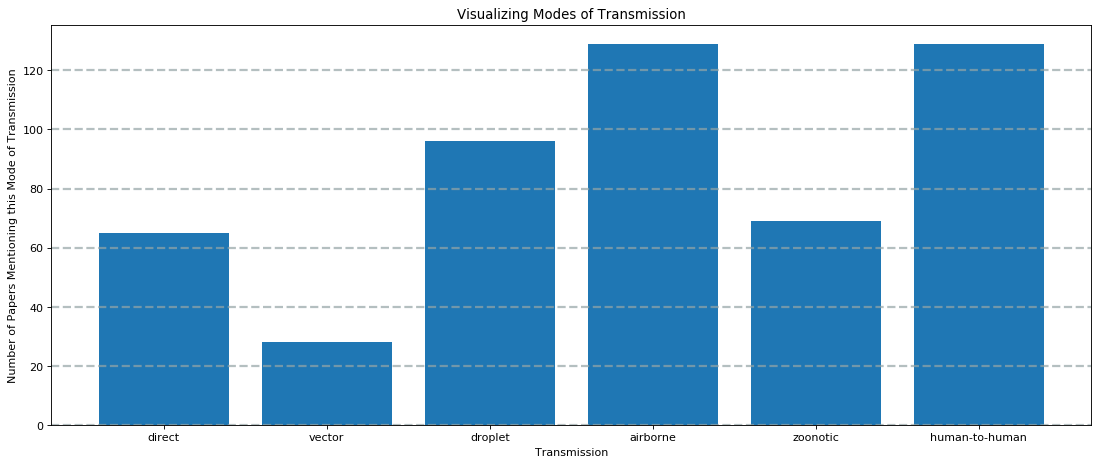

In [26]:
# Lets update the # of mentions of different types of transmissions
transmissions.pop(2)
transmissions.append('zoonotic')
transmissions.append('human-to-human')

transmission_count = dict((transmission,0) for transmission in transmissions)

print(transmission_count)


# Add if statements to attach additional keywords to 'direct' and 'vector'

for transmission in transmission_count:
    for abstract in df_transmission['clean_abstract']:
        if str(transmission) == 'direct':
            if (str(transmission) + ' contact') in abstract:
                transmission_count[transmission] += 1
            elif (str(transmission) + ' transmission') in abstract:
                transmission_count[transmission] += 1
            elif (str(transmission) + ' transmission') in abstract:
                transmission_count[transmission] += 1
            else:
                pass
        elif str(transmission) == 'vector':
            if (str(transmission) + 'borne') in abstract:
                transmission_count[transmission] += 1
            elif (str(transmission) + ' transmission') in abstract:
                transmission_count[transmission] += 1
            else:     
                pass
        elif str(transmission) == 'human-to-human':
            if 'humantohuman' in abstract:
                transmission_count[transmission] += 1
            elif 'human to human' in abstract:
                transmission_count[transmission] += 1
            else:     
                pass
        elif str(transmission) == 'zoonotic':
            if 'zoonotic transmission' in abstract:
                transmission_count[transmission] += 1
            else:     
                pass
        else:       
            if str(transmission) in abstract:
                transmission_count[transmission] += 1


print(transmission_count)

loc = np.arange(len(transmission_count))
width = 0.35

fig = plt.figure(num=None, constrained_layout=True, figsize=(13, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

ax.bar(transmission_count.keys(),transmission_count.values())
ax.set_xticks(loc, tuple(vaccine_types))

ax.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
ax.set_ylabel('Number of Papers Mentioning this Mode of Transmission')
ax.set_xlabel('Transmission')
ax.set_title('Visualizing Modes of Transmission')
plt.show()

Let's now apply different clustering and dimensionality reduction algorithms to reinforce these preliminary findings and discover new insights to inform policy decision making.

# 3. Model Selection & Implementation 

### Vaccines

Let's start by looking at our vaccines dataset. We would like to perform hierarchical clustering on our vaccine types to see if certain vaccine keywords are mentioned together. This may inform the most prominent types of vaccines and the experimental vaccines that are being tested together.

In [27]:
# Define the metric that will be used to define the "distance" metric used in the heirarchical clustering algorithm
vaccine_dist = np.zeros((len(vaccine_types),len(vaccine_types)), dtype=float)
print(vaccine_dist)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [28]:
df_vaccinetypes = pd.DataFrame(vaccine_dist, columns=vaccine_types, index=vaccine_types)
df_vaccinetypes

,attenuated,inactivated,subunit,recombinant vaccine,conjugate,dna vaccine
attenuated,0.0,0.0,0.0,0.0,0.0,0.0
inactivated,0.0,0.0,0.0,0.0,0.0,0.0
subunit,0.0,0.0,0.0,0.0,0.0,0.0
recombinant vaccine,0.0,0.0,0.0,0.0,0.0,0.0
conjugate,0.0,0.0,0.0,0.0,0.0,0.0
dna vaccine,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Helper function that will calculate the distance

def cumulative_dist(type1, type2, df):
    cum_sum = 0
    number_of_papers = 0
    if type1 == type2: return 0
    
    for abstract in df['clean_abstract']:
        if ((type1 in abstract) and (type2 in abstract)):
            number_of_papers += 1
            cum_sum -= 1
        elif (((type1 in abstract) and (type2 not in abstract)) or ((type1 not in abstract) and (type2 in abstract))):
            number_of_papers += 1
            cum_sum += 1
    return cum_sum/number_of_papers


#Populate Matrix of symptom distances by mining the text of the papers found in the database and using the distance rule as

#For a symptom A and B mentioned in a paper together the distanceA_B += 1 
# or distanceA_B -= 1 if they are not mentioned together

vaccine_dist = np.zeros((len(vaccine_types),len(vaccine_types)),float)
vaccine_dist1 = np.zeros((len(vaccine_types),len(vaccine_types)),float)
#print(symptom_dist)
#print()
for i in range(len(vaccine_types)):
    for j in range(len(vaccine_types)):
        vaccine_dist[i][j] = cumulative_dist(vaccine_types[i],vaccine_types[j], df_vaccine)
        vaccine_dist1[i][j] = cumulative_dist(vaccine_types[i],vaccine_types[j], df_vaccine)**6

In [30]:
df_vaccinetypes = pd.DataFrame(vaccine_dist1, columns=vaccine_types, index=vaccine_types)
print('Our distance matrix looks like this:')   
df_vaccinetypes

Our distance matrix looks like this:


,attenuated,inactivated,subunit,recombinant vaccine,conjugate,dna vaccine
attenuated,0.000000,0.208456,0.438419,0.712430,1.000000,0.645350
inactivated,0.208456,0.000000,0.491395,0.732158,1.000000,0.658652
subunit,0.438419,0.491395,0.000000,0.736056,0.827175,0.569234
recombinant vaccine,0.712430,0.732158,0.736056,0.000000,1.000000,0.884747
conjugate,1.000000,1.000000,0.827175,1.000000,0.000000,1.000000
dna vaccine,0.645350,0.658652,0.569234,0.884747,1.000000,0.000000


In [31]:
# Machine Learning
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch

%matplotlib inline

C:\Users\Sam\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


Text(0.5, 1.0, 'Dendrogram Displaying COVID-19 Potential Vaccine Types')

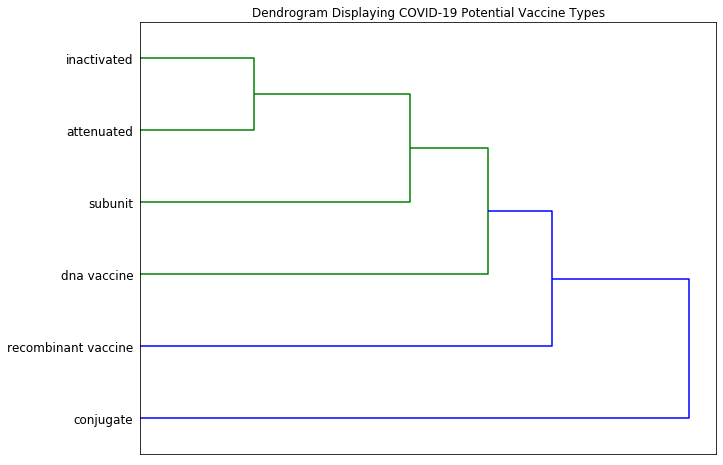

In [32]:
# Distance was magnified prior to Hierarchical Clustering
Y = sch.linkage(vaccine_dist1, method='centroid')

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get the dendrogram
Z1 = sch.dendrogram(Y, orientation='right')

ax1.set_xticks([])
labels = df_vaccinetypes.columns[Z1['leaves']]
ax1.set_yticklabels(labels)
ax1.set_title("Dendrogram Displaying COVID-19 Potential Vaccine Types")
#plt.savefig('COVID_clustering.png', format='png', bbox_inches='tight', dpi=600)

These results show that the most common vaccines ('inactivated' and 'attenuated') are mentioned together. This roughly corresponds to the frequency in which the vaccine type is mentioned. One possibility for these may be that within the abstract, there is an explaination of the two main types of vaccines. These results don't necessarily provide new insight into our overall question: What are the different types of potential vaccines being explored? Instead of assuming we know the different types of vaccines, let's perform K-means clustering to classify the articles automatically.

Since we believe the number of main types of vaccines to be between 4-7, we can start with an intial guess of cluster centres in this range (Note: There is no guarantee that the articles will be clustered on the vaccine types above.). We will use TF-IDF word vectorization as our features. We will then use PCA analysis to allow us to visualize our clustering results in two dimensions.

In [33]:
# Instead of assuming we know the different types of vaccines, let's use K-means clustering
# Use count vectorizer to preprocess data using tf-idf as features
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(df_vaccine['clean_abstract'])
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

Text(0, 0.5, 'Second Principal Component')

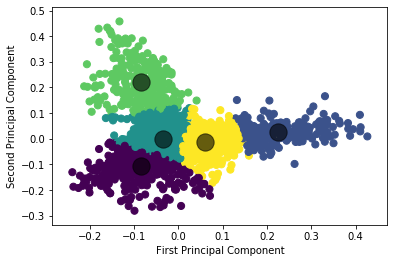

In [34]:
# Based on our research, let's assume their are between 4-7 main types of vaccines being explored
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Find top two principal components for visualization
pca = PCA(n_components = 2)
Y_sklearn = pca.fit_transform(tf_idf_array)
model = KMeans(5) # Use k = 5 to start
model.fit(Y_sklearn)
predicted_values = model.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')


The above diagram shows the predicted cluster value of each sample and the cluster centres. The feature dimensionality has been reduced for visualization. We notice that the data isn't perfectly classified, but maybe a guess of 2-3 clusters would better fit the data after dimensionality reduction. Let's update using 3 cluster centres.

Text(0, 0.5, 'Second Principal Component')

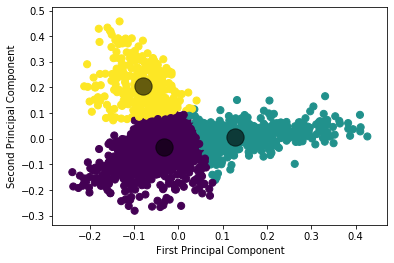

In [35]:
# Update using 3 cluster centres

# Find top two principal components for visualization
pca = PCA(n_components = 2)
Y_sklearn = pca.fit_transform(tf_idf_array)
model = KMeans(3) # Use k = 3
model.fit(Y_sklearn)
predicted_values = model.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Since the features have been reduced, we need a method of understanding our clustering results. We borrow a function that extracts the top words/features from each cluster based on features that correctly predict cluster. 

In [36]:
# This function returns the top words in each cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    
    
    return dfs


Text(0.5, 1.0, 'Top Words Score for Cluster 3')

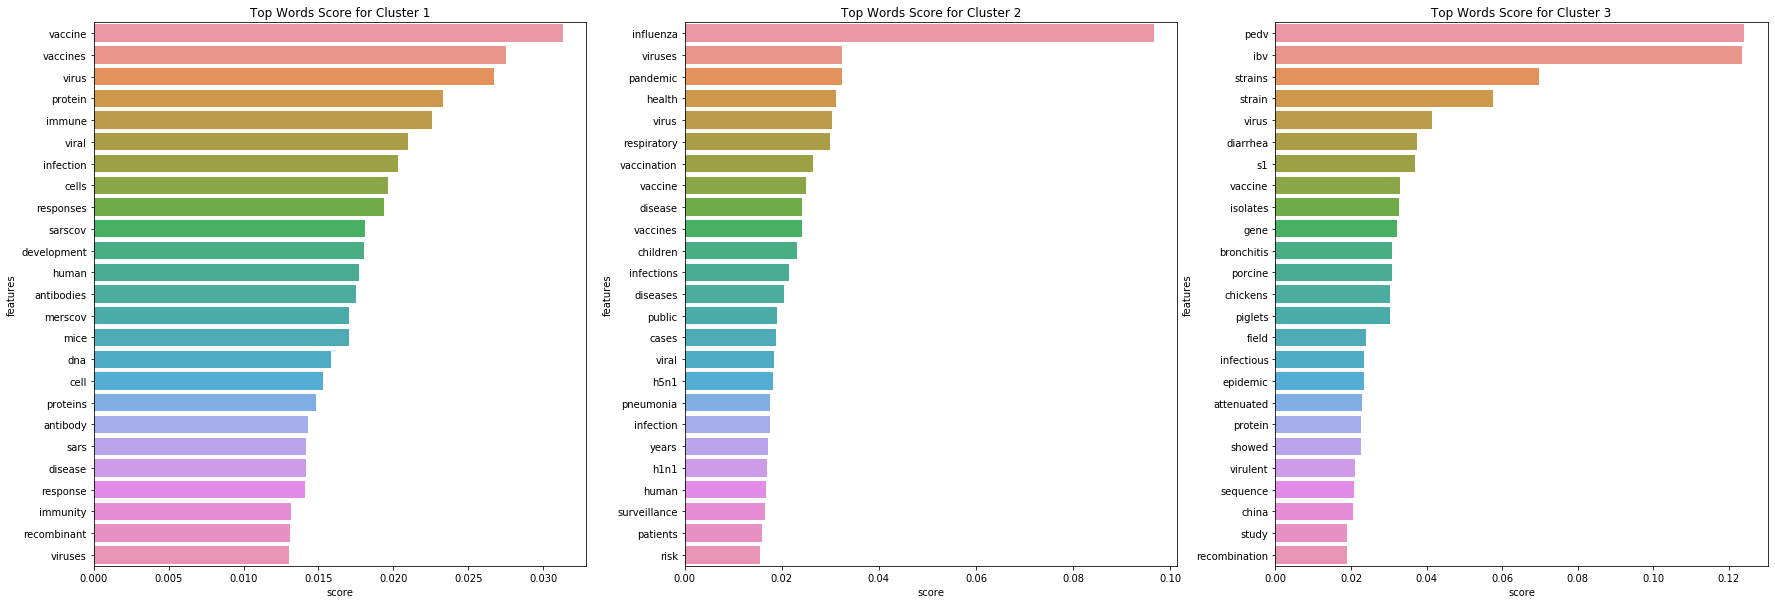

In [37]:
# Lets return the top 25 words from each cluster
dfs = get_top_features_cluster(tf_idf_array, predicted_values, 25)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
sns.barplot(x = dfs[0]['score'], y = dfs[0]['features'], ax = ax1).set_title('Top Words Score for Cluster 1')
sns.barplot(x = dfs[1]['score'], y = dfs[1]['features'], ax = ax2).set_title('Top Words Score for Cluster 2')
sns.barplot(x = dfs[2]['score'], y = dfs[2]['features'], ax = ax3).set_title('Top Words Score for Cluster 3')

I varied the number of clusters and analyzed the findings. I also analyzed the top features without performing dimensionality reduction and found similar results. It seems that the clusters roughly correspond to a specific virus or cluster of viruses. By adding more cluster centres, we see more specific viruses being designated to an entire cluster. This may correspond to overfitting, since we want to broadly identify clusters of similar viruses and how that can inform a search for a potential vaccine. To maintain our generality, we can analyze our results for 3 cluster centres. Note that all clusters include some generic words such as 'vaccine', 'virus', 'protein', etc. We will instead look at words that are cluster specific.

The first cluster includes viruses such as SARS and MERS-COV, both of which are coronavirus strains that are most directly related to the novel coronavirus, COVID-19. These are all respiratory viruses that are yet to have a vaccine that works on humans. The implication here is that epidemioligists can leverage past studies on MERS-COV and SARS as a starting point for vaccine development.

The second cluster includes coronavirus strains such as Porcine Epidemic Diarrhea Virus (PEDV), and Infectious Bronchitous Virus or Avian Coronavirus (IBV). These correspond to coronavirus strains that are prominent in pigs and birds (chickens) respectively, but is not transmissible to humans. While there is still no broadly successful vaccine for PEDV, IBV has both attenuated and inactivated vaccines that work moderately well to produce protective immunity. These studies may also be an excellent resource to leverage in the search for a vaccine.

The third cluster includes influenza viruses such as Swine Flu (H1N1) and Avian Flu (H5N1), which have both produced strains that are transmissible in humans. These viruses are not strains of coronavirus such as the other two clusters, but they can result in similar severe respiratory symptoms such as pneumonia. The H1N1 outbreak in 2009 is the most recent pandemic, and there are moderately successful vaccines that are comparable in their protective immunity to a seasonal flu shot. There are both attenuated and inactivate vaccines.

We will reference these results in our policy decisions discussion.

### Transmission

Lets's now begine our analysis of modes of transmission. We will perform similar algorithms as the ones used above to derive insights on the common modes of transmission of COVID-19 and related coronavirus strains.

Let's start by understanding how the transmission modes are related to eachother through a hierarchical clustering analysis.

In [38]:
# Define the metric that will be used to define the "distance" metric used in the heirarchical clustering algorithm
transmissions = ['direct', 'vector', 'droplet', 'airborne', 'zoonotic', 'humantohuman']
transmission_dist = np.zeros((len(transmissions),len(transmissions)), dtype=float)
print(transmission_dist)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [39]:
df_transmissions = pd.DataFrame(transmission_dist, columns=transmissions, index=transmissions)
df_transmissions

,direct,vector,droplet,airborne,zoonotic,humantohuman
direct,0.0,0.0,0.0,0.0,0.0,0.0
vector,0.0,0.0,0.0,0.0,0.0,0.0
droplet,0.0,0.0,0.0,0.0,0.0,0.0
airborne,0.0,0.0,0.0,0.0,0.0,0.0
zoonotic,0.0,0.0,0.0,0.0,0.0,0.0
humantohuman,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#Populate Matrix of transmission distances by mining the text of the papers found in the database and using the distance rule as

#For a transmission A and B mentioned in a paper together the distanceA_B += 1 
# or distanceA_B -= 1 if they are not mentioned together

transmission_dist = np.zeros((len(transmissions),len(transmissions)),float)
transmission_dist1 = np.zeros((len(transmissions),len(transmissions)),float)
#print(symptom_dist)
#print()
for i in range(len(transmissions)):
    for j in range(len(transmissions)):
        transmission_dist[i][j] = cumulative_dist(transmissions[i],transmissions[j], df_transmission)
        transmission_dist1[i][j] = cumulative_dist(transmissions[i],transmissions[j], df_transmission)**6

In [41]:
df_transmissions = pd.DataFrame(transmission_dist1, columns=transmissions, index=transmissions)
print('Our distance matrix looks like this:')   
df_transmissions

Our distance matrix looks like this:


,direct,vector,droplet,airborne,zoonotic,humantohuman
direct,0.000000,0.447009,0.562757,0.406198,0.469878,0.500325
vector,0.447009,0.000000,0.726094,0.832585,0.473829,0.832585
droplet,0.562757,0.726094,0.000000,0.079876,0.876134,0.713111
airborne,0.406198,0.832585,0.079876,0.000000,0.885842,0.866872
zoonotic,0.469878,0.473829,0.876134,0.885842,0.000000,0.258946
humantohuman,0.500325,0.832585,0.713111,0.866872,0.258946,0.000000


C:\Users\Sam\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


Text(0.5, 1.0, 'Dendrogram Displaying Related Virus Modes of Transmission')

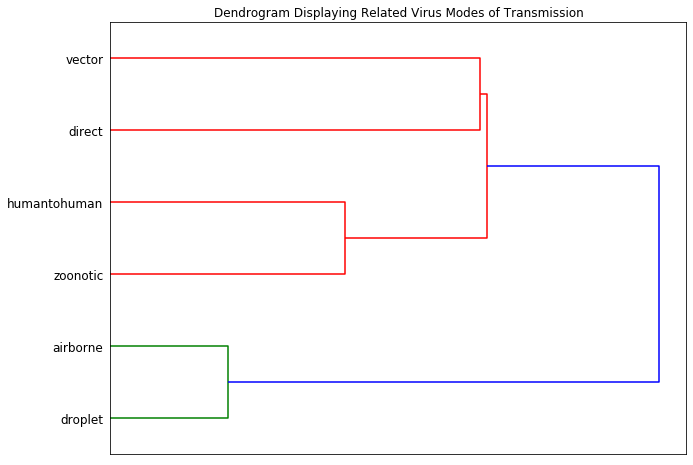

In [42]:
# Distance was magnified prior to Hierarchical Clustering
Y = sch.linkage(transmission_dist1, method='centroid')

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get the dendrogram
Z1 = sch.dendrogram(Y, orientation='right')

ax1.set_xticks([])
labels = df_transmissions.columns[Z1['leaves']]
ax1.set_yticklabels(labels)
ax1.set_title("Dendrogram Displaying Related Virus Modes of Transmission")
#plt.savefig('COVID_clustering.png', format='png', bbox_inches='tight', dpi=600)

This dendogram shows that airborne and droplet transmission are mentioned frequently together while vector and direct transmission are also mentioned together. We can conclude from this graph and intuition that these modes of transmission are closely linked. Droplet transmission represents sneazing/coughing which spreads the virus from and infected individual into the environment through the air, which we can see is closely related to airborne transmission. Vectorborne transmission refers to spreading the virus via a an intermediary (i.e. mosquito, etc.), which is related to direct-contact transmission in that the vector must make contact with an individual to spread the virus to them. In addition, we can see that human-to-human and zoontoic are mentioned together. They are also linked more with direct/vector transmission than airborne/droplet. 

Let's explore K-means clustering and see if the results give more insight into transmission modes. We may expect that the results will be similar to the vaccine results in that they will be clustered by the type of virus. We have narrowed down 2-4 modes of transmission, so let's use k = 4 to start. We will also use PCA to visualize the results as we did for vaccines.

In [43]:
# Use count vectorizer to preprocess data using tf-idf as features
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(df_transmission['clean_abstract'])
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

Text(0, 0.5, 'Second Principal Component')

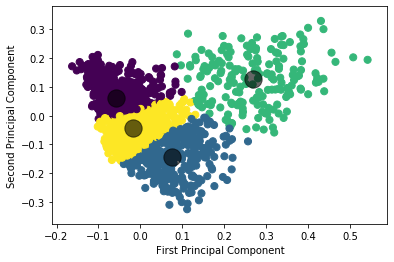

In [44]:
# Find top two principal components for visualization
pca = PCA(n_components = 2)
Y_sklearn = pca.fit_transform(tf_idf_array)
model = KMeans(4) # Use k = 4 to start
model.fit(Y_sklearn)
predicted_values = model.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

The results for the transmission dataset are somewhat different than the vaccines. The decomposition has resulted in a distribution that is densely clustered near the origin and is more sparsely distributed along the first principal component. Let's take a look at the top words for each cluster.

Text(0.5, 1.0, 'Top Words Score for Cluster 4')

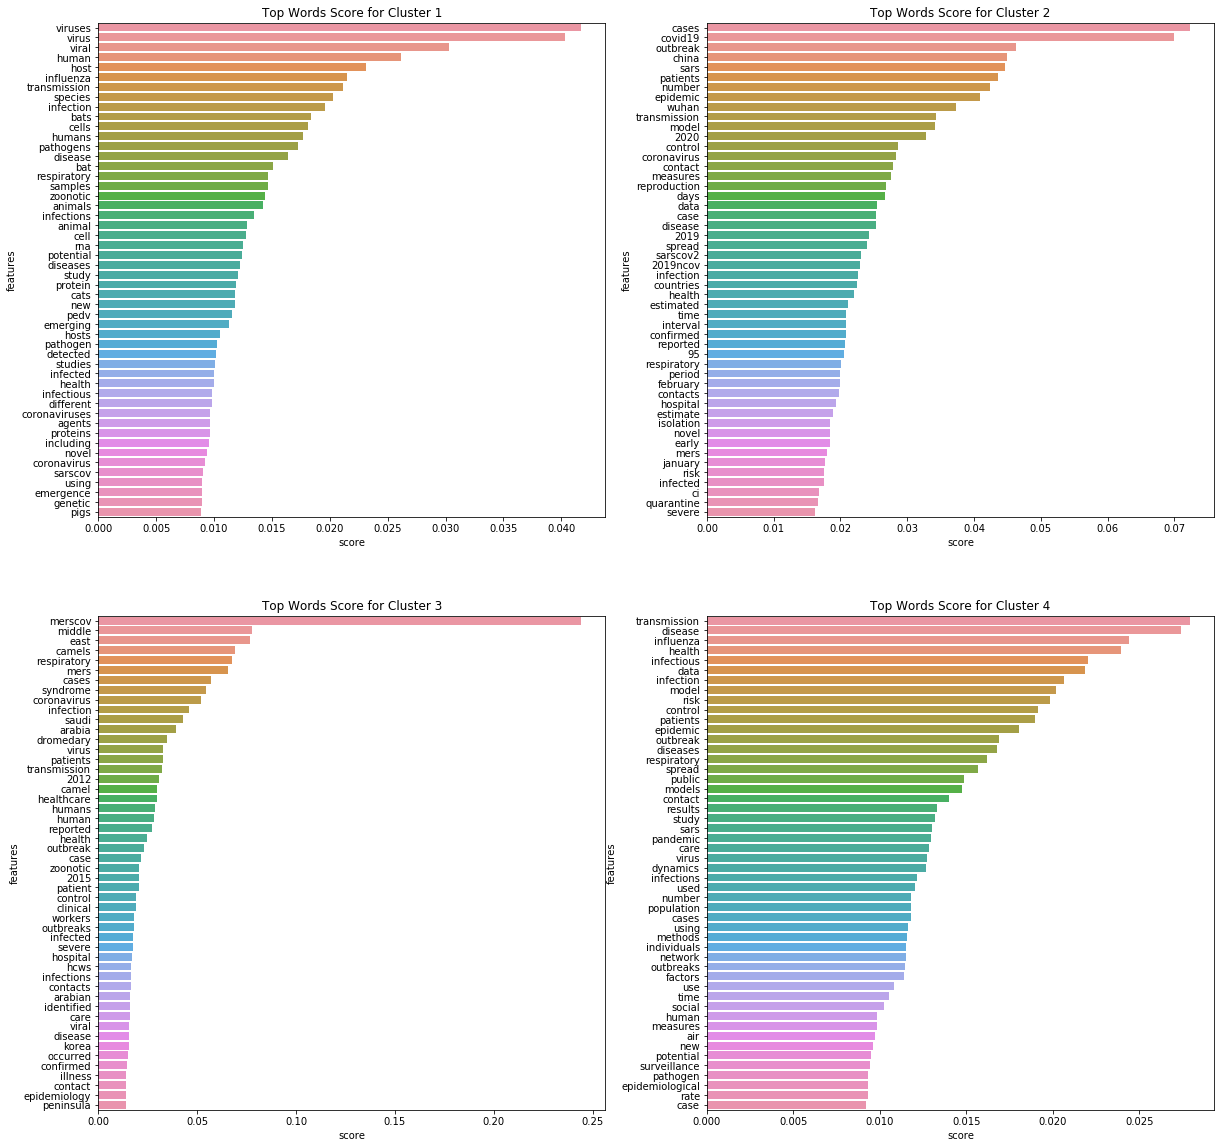

In [45]:
# Lets return the top 20 words from each cluster
dfs = get_top_features_cluster(tf_idf_array, predicted_values, 50)

# Distribution of Predicted Sentiment among parties
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,20))
sns.barplot(x = dfs[0]['score'], y = dfs[0]['features'], ax = ax1).set_title('Top Words Score for Cluster 1')
sns.barplot(x = dfs[1]['score'], y = dfs[1]['features'], ax = ax2).set_title('Top Words Score for Cluster 2')
sns.barplot(x = dfs[2]['score'], y = dfs[2]['features'], ax = ax3).set_title('Top Words Score for Cluster 3')
sns.barplot(x = dfs[3]['score'], y = dfs[3]['features'], ax = ax4).set_title('Top Words Score for Cluster 4')



The top word results contain a mixture of information. Similar to the vaccine results, we observe some clustering by virus type. We also see references to transmission related terminology such as modes of transmission, preventative measures to slow transmission, and zoonotic transmission. There are a large number of generic words in this dataset which is why we took the top 50 words, and we will only consider words that are non-generic in our discussion.

The first cluster seems to relate to the early stages of the 2019-2020 coronavirus outbreak in China. Among the top features is the word contact, which my indicate direct transmission as a potential mode of transmission for COVID-19. We also see specific references to preventative measures used to control and slow the spread of the virus such as 'isolation' and 'quarantine'. Given the "reported" success of controlling the outbreak in Wuhan, these insights may be useful in policy decision making.

The second cluster references numerous animals ('bats', 'cats', 'pigs') as well as diseases that only infect animals such as PEDV. While this clustering isn't as directly related to COVID-19 as the first cluster, it can provide insight into potential zoonotic transmission of other coronavirus strains and how the cross-species transmission may have occured in the case of COVID-19.

The third cluster relates to articles that model the transmission and spread of viruses by identifying potential factors and studying past epidemics. In terms of specific modes of transmission, we observe that 'contact, 'direct', 'human' and 'air' are within the top features, possibly indicating that these are the main transmission modes being modelled for COVID-19. There are also references to 'social', 'public', 'network' and other words pertaining to the rate of transmission. These features may give insight to guide policy decisions regarding the public and large gatherings.

The fourth cluster largely related to the MERS-COV outbreak in Saudi Arabia in 2012. Specific references to 'contact', as well as 'zoontotic' and 'camel' indicate that transmission of this coronavirus strain may have occured from direct contact between camels to humans. Since this is the most recent instance of a novel coronavirus strain, understanding how this disease may have intially spread from animals to humans would give insight into the initial transmission of COVID-19.

We will use these clustering results in our policy decision discussion.

# 4. Policy Discussion
We have text-mined over 35,000 medical articles relating to a number viruses, coranavirus, and other outbreaks in both animal and human populations. We analyzed this data with two key questions in mind: What are the different types of vaccines that are being tested and what are the most prominent modes of transmission for the virus? By answering these questions, we can inform governments, scientists and other organizations on how to potentially guide their search for a vaccine and enforce policies to reduce the transmission of the virus.

### Vaccines

For the topic of vaccines, we have performed exploratory data analysis to understand the frequency of the different types of vacination being discussed within the articles. The results indicated that the two most common types of vaccination (inactive and attenuated) were mentioned most frequently in the articles unsurprisingly. Slightly lesser mentioned vaccine types include sub-unit and DNA vaccines. This is fascinating since DNA vaccines are an extremely recent and current topic of research in academia and industry. While this vaccine may represent an opportunity to test out this new type of vaccine, my reccomendation to scientists and researchers is to attempt to find a vaccine with proven methods that have worked in the past on numerous viruses including other coronavirus strains such as PEDV. My proposal to goverments is to provide additional funding to researchers actively pursuing a vaccination using live-attenuated or inactivated methodologies. The DNA vaccine may be a method of the future, but testing out new vaccine methods during a pandemic represents a large risk for government investment.

We then performed hierarchical clustering to investigate how the different vaccine types related to each other based on how often they were mentioned together. The results were approximately representative of the frequency in which the vaccine types were mentioned. This confirmed our understanding that attenuated and inactivated vaccines are mentioned frequently and also shows that they are mentioned together. However, we may conclude that hierarchical clustering isn't the most insightful algorithm for this type of analysis, since we are actually looking for differences in the types of vaccine.

K-means clustering was used to classify the articles based on TF-IDF word features within the articles. The initial hypothesis was that the clusters may indicate the type of vaccination. However, it was found that the clusters approximately represented classifications of different viruses based on certain characteristics. The three clusters included human transmissible coronavirus strains (SARS, MERS), non-human transmissible coronavirus strains (PEDV, IBV), and influenza strains (common flu, H1N1, H5N1). While this clustering analysis doesn't directly answer our initial question of which types of potential vaccines to explore, it does indicate medical research that can be used to guide a search for new vaccines. The most relevant cluster includes the set of research papers relating to coronaviruses that are human-transmissible, since this best matches the characteristics of COVID-19. The problem is that there is currently no successful vaccine that has been implemented for SARS or MERS. Alternatively, the cluster containing non-human transmissible diseases includes PEDV, which is a coronavirus strain that infects pigs and has a moderately successful vaccine. I reccomend scientists to explore research within these two clusters as starting points for further research on COVID-19. I also reccomend that the Canadian government contact the researchers who produced the vaccination for PEDV and collaborate on a joint research project. It should be noted that of the multiple vaccines for PEDV, only attenuated and inactivated methodologies have proven successful. This further validates our reccomendation to fund research for attenuated and inactivated potential vaccines. 

### Transmissison

For the topic of transmission, we performed a similar exploratory analysis looking at the different modes of transmission and the frequency in which they are mentioned within the articles. The analysis was slightly more difficult due to the ambiguity of some of the keywords such as 'direct' or 'vector'. The results indicated that droplet and airborne transmission were the most commonly mentioned of the five overarching transmission modes. Direct contact and vectorborne transmission were mentioned slightly less. Subcategories of transmission include human-to-human and zoonotic (animal-to-human), where it was found that human-to-human was mentioned slightly more frequently.

Hierarchical clutering was performed to analyze how frequently the different modes of transmission were mentioned together. This may give insight into how different types of viruses are transmitted by multiple modes of transmission, since these modes are not mutually exclusive. We found that the transmission modes were grouped as follows, with the strongest groupings listed first: (airborne, droplet), (human-to-human, zoonotic), and (vector, direct). These results may indicate that if a virus is transmissible by air, it may also be likely to be transmissible by droplets. We must also remember that due to the special treatment of the words 'vector' and 'direct', their results may be slightly under represented in the analysis. 

Finally, K-means clustering was performed with the goal of classifying the articles based on modes of transmission, but also with the newly gained insight that the clustering may be based on the type of virus similar to the vaccine clustering results. Ultimately, the results were mixed and I observed both clustering based on virus type and transmission modelling, both of which yielded interesting insights. 

The first cluster related to the early stages of the COVID-19 outbreak in China and some of the preventative measures that they inacted. The clustering indicates that isolation and quarantine were implemented. Based on the successful control of COVID-19 in China, I reccomend the Canadian government implement the following policies: Mandatory isolation and quarantine for all non-essential workers. The Canadian government has included far too many services on their list of 'essential' services. This reccomendation would include tightened restrictions on this list so that the vast majority of the population, especially in urban areas, is forced to stay home. The third cluster also mentions methods of transmission such as 'contact, 'direct', 'human' and 'air', as well as potential factors used to model the transmission of COVID-19. Based on this cluster, I would validate and reinforce the current government policies regarding the limitation of social gatherings and large groups of people. Combining this information with the frequency of airborne and droplet transmission in the articles, I would enforce a policy that makes it mandatory for all essential workers to wear a certified N-95 mask to prevent these modes of transmission. 

The second cluster references coronavirus strains that are only transmissible within animals. It is believed that COVID-19 initiated from a coronavirus strain within animals and developed the ability to spread to humans. It is my reccomendation to scientists that they reference the articles in this cluster to investigate potential coronavirus strains that COVID-19 may have stemmed from. From the fourth cluster relates predominantly to MERS, which is a coronavirus strain that has been linked to a few different animals, and may have initially spread to humans from camels. This zoonotics transmission may also give insight into how COVID-19 initially spread into the human population. My reccomendation to scientists researching COVID-19's potential for cross-species and zoonotic transmission is to utilize the research within these clusters and work with leading scientists who have studied the zoonotic transmission of MERS.